In [1]:
# Load imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [5]:
# Load cleaned dataset
df = pd.read_csv("online_retail_cleaned.csv", parse_dates=["InvoiceDate"])
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,InvoiceMonth
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,2010-12
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,2010-12
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12
...,...,...,...,...,...,...,...,...,...,...
392687,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,10.20,2011-12
392688,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,12.60,2011-12
392689,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60,2011-12
392690,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60,2011-12


In [32]:
# STEP 1: Create RFM Table
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',                                   # Frequency
    'TotalPrice': 'sum'                                       # Monetary
}).rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalPrice': 'Monetary'
}).reset_index()

# RFM Check
print(rfm.describe())

         CustomerID      Recency    Frequency       Monetary
count   4338.000000  4338.000000  4338.000000    4338.000000
mean   15300.408022    92.536422     4.272015    2048.688081
std     1721.808492   100.014169     7.697998    8985.230220
min    12346.000000     1.000000     1.000000       3.750000
25%    13813.250000    18.000000     1.000000     306.482500
50%    15299.500000    51.000000     2.000000     668.570000
75%    16778.750000   142.000000     5.000000    1660.597500
max    18287.000000   374.000000   209.000000  280206.020000


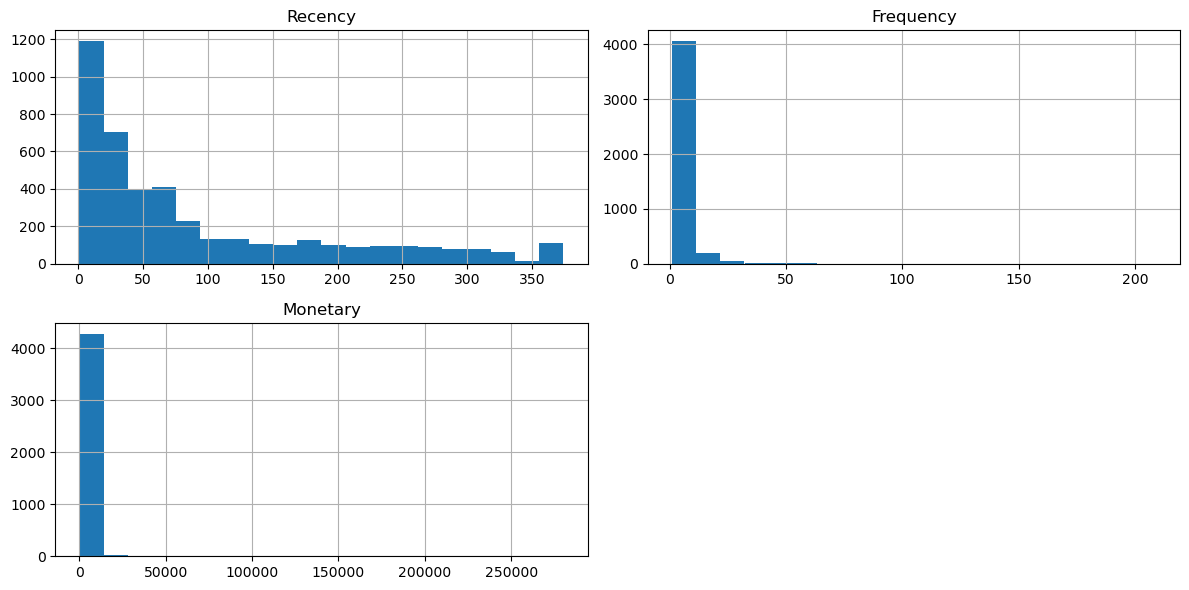

In [33]:
# Histogram of RFM values
rfm[['Recency', 'Frequency', 'Monetary']].hist(bins=20, figsize=(12,6))
plt.tight_layout()
plt.show()

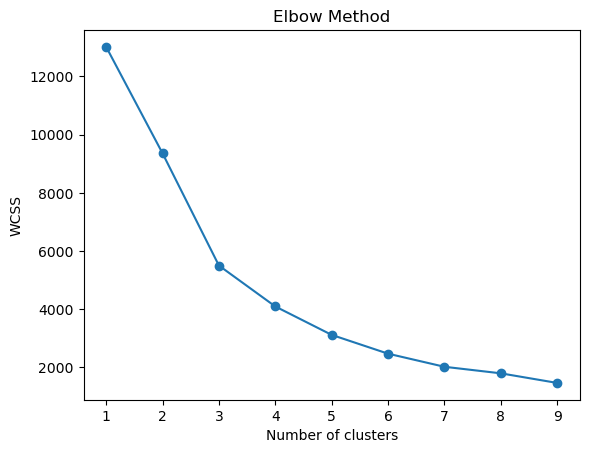

In [34]:
# STEP 2: Standardize RFM for Clustering
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

# Elbow Method to Choose k
wcss = []
for i in range(1, 10):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(rfm_scaled)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 10), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [36]:
# STEP 3: Apply KMeans Clustering (k=4)
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

In [40]:
# STEP 4: Visualize Cluster Summary
rfm.groupby('Cluster').mean().round(2)

,CustomerID,Recency,Frequency,Monetary
Cluster,,,,
0,15289.13,43.70,3.68,1353.63
1,15347.79,248.08,1.55,478.85
2,15435.00,7.38,82.54,127187.96
3,15212.86,15.50,22.33,12690.50


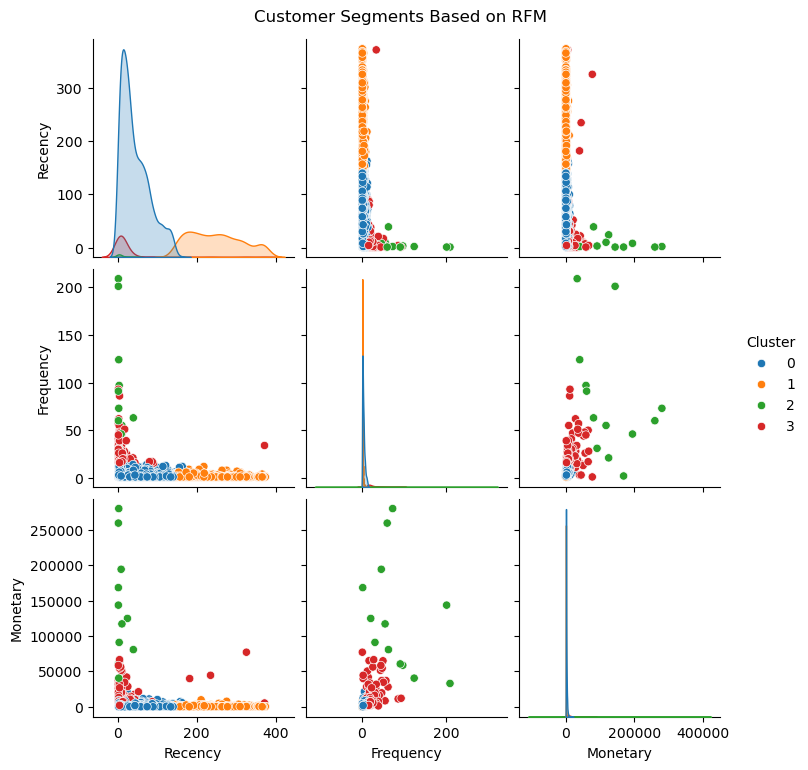

In [42]:
# Pairplot of Clusters
sns.pairplot(rfm, hue='Cluster', vars=['Recency', 'Frequency', 'Monetary'], palette='tab10')
plt.suptitle("Customer Segments Based on RFM", y=1.02)
plt.show()

In [46]:
# Save clustered RFM for next notebook
rfm.to_csv("rfm_clustered.csv", index=False)